<a href="https://colab.research.google.com/github/drdww/OPIM5641/blob/main/Module6/M6_1/1_Location_Problem_Simple_guided.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonlinear Optimization: Warehouse Location (simple) - guided
---------------------------------------------------
**OPIM 5641: Business Decision Modeling - University of Connecticut**

Please refer to Powell Ch. 8 for more details and examples.

IPOPT documentation: https://coin-or.github.io/Ipopt/

-----------------------------------------------

In [ ]:
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path
import numpy as np

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        #!apt-get install -y -qq glpk-utils
    else:
        try:
            !conda install -c conda-forge ipopt
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

Kilroy Paper Company distributes specialty papers to big-box stores in ten major U.S. metropolitan
areas and plans to consolidate its warehouses into one national distribution center (DC). To identify
a suitable location, Kilroy’s distribution manager first maps the ten stores on a two-dimensional grid,
so that coordinates (xk, yk) can be associated with each site. These values are shown in the following
table:

Site ($k$)| $x_k$| $y_k$
---|---|---|
1| 5| 41
2| 20| 10
3| 44| 48
4| 60| 58
5| 100| 4
6| 138| 80
7| 150| 40
8| 170| 18
9| 182| 2
10| 190| 56

For any distribution center location ($x$, $y$), it is possible to calculate the distance from the DC to each
of the stores and to sum the distances. This total can be thought of as a proxy for the total annual cost
incurred by Kilroy’s trucks, since they will make regular trips to the individual stores. Minimizing the
sum of distances therefore represents an objective that is consistent with minimizing annual
distribution cost. Kilroy wishes to determine the location that achieves the minimum sum of
distances.

# Background (2D Distances)

**What is our objective?** To minimize this distance between the DC and the stores. We need to predict the XY coordinates of the DC.

What is a good measure of distance? The Euclidean distance formula.

For each store $k$, we can calculate the pairwise distance between the store and the DC.

$D_k(x,y) = \sqrt{(x-x_k)^2 + (y-y_k)^2}$

And we will repeat this 10 times (one for each store, DC pair) and try to minimize this quantity.

$f(x,y)=\Sigma_{k=1}^{10}D_k(x,y)$

That's it! Now let's go build a model.

# Model Setup
As mentioned, our objective is to minimize the sum of the pairwise distance between stores.

$Min(\Sigma_{k=1}^{10}D_k(x,y))$

You are just looking for the geographic centroid between the points.

And we have no constraints! Let's see how to do this.

## Visualizing the problem
... can be very helpful!

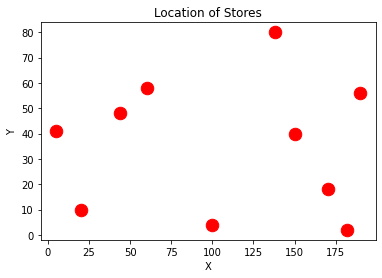

In [ ]:
# specify X and Y coords of each store
import numpy as np
X = np.array([5, 20, 44, 60, 100, 138, 150, 170, 182, 190])
Y = np.array([41, 10, 48, 58, 4, 80, 40, 18, 2, 56])

# show a map!
# with pylab, we can cut down on some of the typing...
from pylab import *
plot(X,Y, '.', markersize=25, color='red') # '.' plots them as dots on a scatterplot
title('Location of Stores')
xlabel('X')
ylabel('Y')
plt.show() # gets rid of annoying text

Looking at the above map, where would you put the dot? Might be easy if only 2D, but later on, we will get more sophisticated and add other criterion... more later...

# ConcreteModel

In [ ]:
# declare the model
model = ConcreteModel()

# Declare Decision Variables
Our decision variables and constraints are going to be a bit intertwined. We want to minimize the distances from each of the 10 stores to the distribution center. So we need to find a coordinate corresponding to the lat/lon (X/Y) coordinate of the distribution center: $x_k$ and $y_k$.

In [ ]:
# number of stores (there are 10)
n_points = len(X)

# declare decision variables
# remember, we should  intialize a value here (you can try different ones)
# and we need to provide real bounds to help convergence
model.Xcoord = Var(domain=Reals,bounds = (0,200), initialize=0)
model.Ycoord = Var(domain=Reals, bounds = (0,100), initialize=0)

# and this is to store the intermediate Distances as we try to find optimal Xcoord and Ycoord
model.Dist = Var([i for i in range(n_points)],domain=Reals, initialize=0)

model.pprint()

1 Set Declarations
    Dist_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

3 Var Declarations
    Dist : Size=10, Index=Dist_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :     0 :  None : False : False :  Reals
          1 :  None :     0 :  None : False : False :  Reals
          2 :  None :     0 :  None : False : False :  Reals
          3 :  None :     0 :  None : False : False :  Reals
          4 :  None :     0 :  None : False : False :  Reals
          5 :  None :     0 :  None : False : False :  Reals
          6 :  None :     0 :  None : False : False :  Reals
          7 :  None :     0 :  None : False : False :  Reals
          8 :  None :     0 :  None : False : False :  Reals
          9 :  None :     0 :  None : False : False :  Reals
    Xcoord : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : St

For now, we have declared two decision variables and 10 other distance-related variables that are intermediate calculations that will be used in a moment to calculate the objective function.

At this point, we haven't shown how `model.Xcoord` ($x_k$) and `model.Ycoord` ($y_k$) - the centroids of the distribution center - have been used yet. But we set up a helpful skeleton to fill everything in.

# Declare Constraints
Now, this is where your distance function is going to live! You are going to enforce that the distance between the distribution center and the $i$th warehouse of interest is accounted for as such.

For each of the ten points - 


In [ ]:
# Constraints
model.constraints = ConstraintList()

# Pairwise values from DC to store (loops 10 times)
for i in range(n_points):
  x = X[i] # grab the i-th x location (starting with 0)
  y = Y[i] # grab the i-th y location (starting with 0)
  model.constraints.add(model.Dist[i] == ((model.Xcoord-x)**2 + (model.Ycoord-y)**2)**0.5) # calculate and store euclidean distance

# show the model you've created
model.pprint()

2 Set Declarations
    Dist_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

3 Var Declarations
    Dist : Size=10, Index=Dist_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :     0 :  None : False : False :  Reals
          1 :  None :     0 :  None : False : False :  Reals
          2 :  None :     0 :  None : False : False :  Reals
          3 :  None :     0 :  None : False : False :  Reals
          4 :  None :     0 :  None : False : False :  Reals
          5 :  None :     0 :  None : False : False :  Reals
          6 :  None :     0 :  None : False : False :  Reals
          7 :  None :     0 :  None : False : False :  Reals
          8 :  None :  

# Objective Function
Now, you have filled in those 10 `Dist` (distance) placeholders between all of the warehouses (X,y - dynamically updated in the for loop) and the distribution center (Xcoord, Ycoord).

In [ ]:
# declare objective
# we are trying to minimize the distance
obj_expr = 0 # intialize the objective as a 0...
for i in range(n_points):
  obj_expr += model.Dist[i]

# obj_expr += modelDist[i] is the same thing as 
# obj_expr = obj_expr + model.Dist[i]!!!!

model.error = Objective(
                      expr = obj_expr,
                      sense = minimize)

# show the model you've created
model.pprint()

2 Set Declarations
    Dist_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

3 Var Declarations
    Dist : Size=10, Index=Dist_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :     0 :  None : False : False :  Reals
          1 :  None :     0 :  None : False : False :  Reals
          2 :  None :     0 :  None : False : False :  Reals
          3 :  None :     0 :  None : False : False :  Reals
          4 :  None :     0 :  None : False : False :  Reals
          5 :  None :     0 :  None : False : False :  Reals
          6 :  None :     0 :  None : False : False :  Reals
          7 :  None :     0 :  None : False : False :  Reals
          8 :  None :  

Now you can clearly see that you are trying to minimize the distances - and each `Dist[0]` is the Euclidean distance between the individual warehouse and the distribution center (`model.Xcoord`, `model.Ycoord` your decision variables)

# Solve!

Now let's run it!

In [ ]:
# solve it
SolverFactory('ipopt', executable='/content/ipopt').solve(model).write()
# show the results
print("Objective value = ", model.error())
print("Xcoord = ", model.Xcoord())
print("Ycoord = ", model.Ycoord())

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 10
  Number of variables: 12
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.02464580535888672
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Objec

Great! Now show the map with your new Distribution Center (DC) on it!

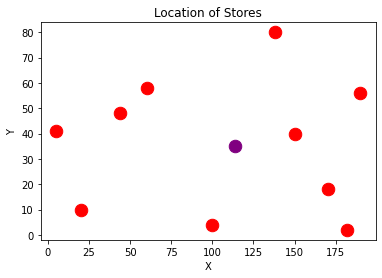

In [ ]:
# show a map!
from pylab import *
plot(X,Y, '.', markersize=25, color='red') # '.' plots them as dots on a scatterplot
title('Location of Stores')
xlabel('X')
ylabel('Y')
# let's add the ANSWER as a purple dot
plot(model.Xcoord(),model.Ycoord(), '.', markersize=25, color='purple')
plt.show() # gets rid of annoying text

# What do you see?
It looks like we have found the centroid of the point mass, as a function of Euclidean distance.

# On Your Own...
How do you think you could account for other data - like the number of deliveries made to each of the 10 stores?

Maybe you could also try a few different distance metrics...
![comparison of distances](https://miro.medium.com/max/1400/1*vAtQZbROuTdp36aQQ8cqBA.png)
